# Portfolio Analysis with Statistics

## Data ETL

To access stock data, we will use the [yfinance library](https://github.com/ranaroussi/yfinance). We first download the historical monthly stock prices for the chosen stocks/tickers(slightly modifying the code in the library tutorial). The data comes in the form of a pandas dataframe with multi-level headers, so we also unstack the levels for simpler access.

In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd
#ticks = ["AMD", "GE", "MSFT", "PILL", "TQQQ", "XLV", "TSLA"]
#ticks = pd.read_csv("nasdaq_screener.csv")['Symbol'].tolist()
ticks = pd.read_csv("constituents_csv.csv")['Symbol'].tolist()
data = yf.download(tickers = ['^GSPC'] + ticks, start = '2016-06-01', period = '1mo', interval = '1mo', group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)

[*********************100%***********************]  506 of 506 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [2]:
# unstack
stocks_raw = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
stocks_raw = stocks_raw.groupby('Ticker').filter(lambda x: len(x) > 36)
stocks_raw = stocks_raw.sort_values(by=['Date', 'Ticker'])
stocks_raw

,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2016-06-01,A,NaN,42.381901,44.598447,40.108029,43.709917,5.201100e+07
2016-06-01,AAL,NaN,27.206568,32.271163,23.881428,30.695083,2.742468e+08
2016-06-01,AAP,NaN,158.048325,158.194995,145.219050,150.430941,2.675870e+07
2016-06-01,AAPL,NaN,22.327021,23.796027,21.369481,23.125748,3.117991e+09
2016-06-01,ABBV,NaN,49.456955,52.220987,46.597065,50.271785,2.116455e+08
...,...,...,...,...,...,...,...
2021-07-13,ZBH,NaN,157.369995,160.199997,156.789993,159.490005,4.903710e+05
2021-07-13,ZBRA,NaN,533.884399,546.359985,531.940002,546.359985,1.215520e+05
2021-07-13,ZION,NaN,51.860001,52.580002,51.230000,52.549999,6.119710e+05


Since we only want one stock price per month, we filter out the last row of each asset if it does not fall on the first day of the month. We also only keep the last 5 years of data to maintain an accurate representation of each company's relevant returns(profitability in the 1990s does not entail profitability in 2020s). Because we require the previous month's price to compute the current month's return, we need to keep an extra month(a total of 61 months)

In [3]:
recent = stocks_raw.index[-1] - pd.DateOffset(day = 1)
stocks = stocks_raw.loc[stocks_raw.index <= recent].copy()
#sp500 = sp500_raw.loc[(sp500_raw.index <= recent) & (sp500_raw.index >= begin)].copy()

To compute the (percent) return of a specified observation, we subtract the current price with last month's price and divide by last month's price. We can easily vectorize this by subtracting an array of the (open) prices without the last observation from an array of the (open) prices without the first observation. We then divide by the former.  

To make calculating parameters easier, we can pivot the dataframe such that each ticker's percent returns form individual columns. Note that we need to mask the data matrix to ignore NaN values. 

In [4]:
pivoted = stocks.pivot(columns = 'Ticker', values = 'Open').dropna(axis=1, how='all')
spprices = pivoted['^GSPC'].to_numpy()
pivoted = pivoted.drop(columns = ['^GSPC'])
prices = pivoted.to_numpy()
returnarr = prices[1:, :] - prices[:(prices.shape[0] - 1), :]
returnarr = returnarr /  prices[:(prices.shape[0] - 1), :]
spreturns = (spprices[1:] - spprices[:(len(spprices) - 1)]) / spprices[:(len(spprices) - 1)]

## SIM and weight calculations

Next we compute the single index model parameters and store them in a dataframe, which includes C values. Finally we determine the assets above the cutoff point and compute the portfolio weights. 

In [5]:
betas = np.zeros(returnarr.shape[1])
alphas = np.zeros(returnarr.shape[1])
unsyserr = np.zeros(returnarr.shape[1])
for i in np.arange(returnarr.shape[1]):
    treturn = returnarr[:,i]
    tnonan = treturn[np.logical_not(np.isnan(treturn))]
    spmatch = spreturns[(len(spreturns) - len(tnonan)):]
    try:
        betas[i], alphas[i], r, p, se = stats.linregress(spmatch, tnonan)
    except: 
        print(returnarr[:,i])
    unsyserr[i] = np.sum((tnonan - alphas[i] - betas[i]*spmatch)**2) / (len(spmatch) - 2)

In [6]:
returnmean = returnarr.mean(axis = 0)
simdf = pd.DataFrame(data = {'alpha': alphas, 'beta': betas, 'eps': unsyserr, 'rmean': returnmean}, index = pivoted.columns.values)
simdf['excess'] = simdf['rmean'] / simdf['beta']
simdf = simdf.sort_values(by=['excess'], ascending = False)
simdf = simdf.loc[(simdf['excess'] > 0) & (simdf['beta'] > 0)]

In [7]:
simdf

,alpha,beta,eps,rmean,excess
NLOK,0.026792,0.209769,0.029112,0.029519,0.140722
CTXS,0.010506,0.127214,0.005378,0.012160,0.095587
NEE,0.015106,0.221104,0.002370,0.017980,0.081320
SBAC,0.017837,0.266114,0.003727,0.021296,0.080026
DLR,0.009856,0.166768,0.003150,0.012024,0.072098
...,...,...,...,...,...
CAH,-0.012217,1.030792,0.004805,0.001182,0.001147
UAA,-0.016811,1.366720,0.015793,0.000955,0.000699
CPB,-0.007125,0.562182,0.004031,0.000183,0.000325
VNO,-0.017915,1.391621,0.004305,0.000175,0.000126


In [8]:
num = simdf['rmean'] * simdf['beta'] / simdf['eps']
den = simdf['beta']**2 / simdf['eps']
simdf['C'] = spreturns.var() * num.cumsum() / (1 + spreturns.var() * den.cumsum())

In [9]:
cutoff = simdf.loc[simdf['C'] < simdf['excess']]
z = (cutoff['beta'] / cutoff['eps']) * (cutoff['excess'] - cutoff['C'])
weights = z.sort_values(ascending = False) / z.sum()
weights.head()

NEE     0.109220
SBAC    0.079013
RMD     0.067225
LLY     0.061293
AMT     0.058090
dtype: float64

## Portfolio Details

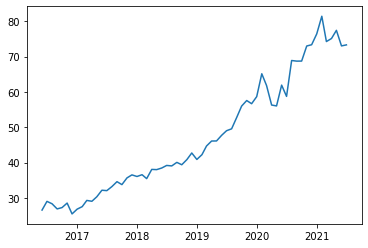

In [10]:
import matplotlib.pyplot as plt
plt.plot(stocks.loc[stocks['Ticker'] == weights.index[0], 'Open'])
plt.show()

In [11]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')
latest_raw = yf.download(tickers = weights.index.values.tolist(), start = today_date, period = '1d', interval = '1d', group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)

[*********************100%***********************]  39 of 39 completed


In [12]:
latest = latest_raw.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
latest.head()

,Ticker,Close,High,Low,Open,Volume
Date,,,,,,
2021-07-13,AEE,83.169998,83.400002,82.650002,82.820000,329397
2021-07-13,AMT,279.250000,281.619995,278.070007,278.140015,660214
2021-07-13,AWK,163.195007,163.899994,162.509995,162.839996,152939
2021-07-13,BKR,22.530001,22.900000,22.322001,22.790001,3791283
2021-07-13,CCI,201.250000,203.279999,200.889999,201.649994,494684


In [13]:
latest_prices = latest.set_index('Ticker', drop=True).loc[weights.index.values, 'Close']
portvalue = 10000
numstocks = portvalue*weights/latest_prices
numstocks

NEE     14.487135
SBAC     2.395890
RMD      2.702613
LLY      2.600015
AMT      2.080206
AWK      3.445809
DLR      3.288509
EXR      2.614109
EQIX     0.456781
CTXS     3.003078
GNRC     0.658536
TTWO     1.679165
PGR      2.602024
PSA      0.803906
NEM      3.825192
MKTX     0.509825
CLX      1.259171
DPZ      0.432053
WEC      2.081889
ENPH     1.013597
CCI      0.908102
TMUS     1.053975
NLOK     5.655846
NFLX     0.274890
DXCM     0.327258
CMS      2.050523
NVDA     0.121285
XEL      1.244525
HSY      0.464872
IDXX     0.122394
ZTS      0.364460
AEE      0.837101
TWTR     0.900748
MSFT     0.179893
CME      0.191706
REGN     0.054007
POOL     0.051698
ETSY     0.059847
BKR      0.173927
dtype: float64

In [16]:
sum(numstocks*latest_prices)

10000.000000000002

In [14]:
date1 = stocks.loc[(stocks.index == '2021-05-01') & (stocks['Ticker'] != '^GSPC')].set_index('Ticker', drop=True)
date1 = date1.loc[weights.index.values, 'Close']
date2 = stocks.loc[(stocks.index == '2021-07-01') & (stocks['Ticker'] != '^GSPC')].set_index('Ticker', drop=True)
date2 = date2.loc[weights.index.values, 'Close']
print(date1.head())
print(date2.head())
percchange = (date2 - date1) / date1
sum(percchange * weights)

Ticker
NEE      72.834999
SBAC    297.526489
RMD     205.437775
LLY     198.861237
AMT     254.242767
Name: Close, dtype: float64
Ticker
NEE      74.989998
SBAC    329.329987
RMD     247.679993
LLY     234.990005
AMT     278.450012
Name: Close, dtype: float64


0.08608053900646569

In [15]:
spdate1 = stocks.loc[(stocks.index == '2021-05-01') & (stocks['Ticker'] == '^GSPC')]['Close'].values
spdate2 = stocks.loc[(stocks.index == '2021-07-01') & (stocks['Ticker'] == '^GSPC')]['Close'].values
print(spdate1)
print(spdate2)
(spdate2 - spdate1) / spdate1

[4204.10986328]
[4369.54980469]


array([0.03935195])

In [10]:
import pymysql.cursors

# Connect to the database
connection = pymysql.connect(host='localhost',#host='192.168.68.101',
                             user='edwin',
                             password='edwin',
                             database='charles',
                             cursorclass=pymysql.cursors.DictCursor)


OperationalError: (2003, "Can't connect to MySQL server on 'localhost' ([WinError 10061] No connection could be made because the target machine actively refused it)")